In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import glob
import os
import warnings
from pyspark.sql import SparkSession

from scipy.interpolate import CubicSpline, PchipInterpolator, Akima1DInterpolator
from sklearn.impute import SimpleImputer, KNNImputer

# Rattle-Newton
import ThermaNewt.sim_snake_tb as therma_sim


warnings.filterwarnings('ignore')

In [4]:
t_pref_min_bounds = (0, 25)
print(t_pref_min_bounds[1])

25


In [9]:
def key_gen(*args):
    key = ''
    for i in args:
        key+=str(i)
    return key

def bin_to_nearest(minute_value, minute_interval=30):
    if minute_interval <= 0 or 60 % minute_interval != 0:
        raise ValueError("Invalid minute interval")
    num_bins = 60 // minute_interval
    bin_value = (minute_value // minute_interval) * minute_interval
    return bin_value

In [3]:
minute_value = 20
minute_interval = 10
print(bin_to_nearest(minute_value, minute_interval))

20


## Load Data

In [4]:
## Otm_Data
otm_fp = '../Data_Sets/OTM_Main_Database.csv'
otm_data = pd.read_csv(otm_fp, index_col=0)
otm_data['Date'] = pd.to_datetime(otm_data['Date'])
otm_data = otm_data.drop(columns=['Lat', 'Long'])
microhabitat = []
for index, row in otm_data.iterrows():
    if row['OTM_ID']=='Air Temperature':
        micro = 'Air_Temperature'
    else:
        micro = row['Microhabitat']
    microhabitat.append(micro)
otm_data['Microhabitat'] = microhabitat

spark = SparkSession.builder.appName("PandasToSparkPivot").getOrCreate()
spark_df = spark.createDataFrame(otm_data)

# Pivot the Spark DataFrame
otm_df = spark_df.groupBy('Date', 'year', 'month',
                          'day','hour','minute', 'season',
                          'Study_Site').pivot("Microhabitat").agg({"Temperature": "mean"})

# Display the pivoted Spark DataFrame
otm_data = otm_df.toPandas()
otm_data = otm_data.sort_values(by=['Date', 'Study_Site'], ascending=True).reset_index()

# otm_data['nearest_min'] = otm_data.apply(lambda row: bin_to_nearest(row['minute']), axis=1)
    

# otm_data['key'] = [key_gen(row['Study_Site'],
#                            row['year'], row['month'], row['day'],
#                            row['hour'], row['nearest_min']) for index, row in otm_data.iterrows()]

FileNotFoundError: [Errno 2] No such file or directory: '../Data_Sets/OTM_Main_Database.csv'

In [4]:
duplicates = otm_data[otm_data.duplicated(subset=['Date', 'Study_Site'], keep=False)]
print(len(duplicates))

0


In [49]:
otm_data['Study_Site'].unique()

array(['Texas-Marathon', 'Nebraska', 'Canada', 'Texas-Monohans'],
      dtype=object)

In [48]:
snake_data['Study_Site'].unique()

array(['Texas-Marathon', 'Canada', 'Nebraska'], dtype=object)

In [10]:
## Snake ibutton Data
dead_snakes = ['Dusty', 'Bjorn']
snake_fp = 'snake_thermal_database.csv'
snake_data = pd.read_csv(snake_fp, index_col=0)
snake_data['Date'] = pd.to_datetime(snake_data['Date'])
snake_data = snake_data[~snake_data["Snake_Name"].isin(dead_snakes)]
#snake_data['nearest_min'] = snake_data.apply(lambda row: bin_to_nearest(row['minute']), axis=1)
snake_data = snake_data[~((snake_data['Snake_Name'].isin(['Eddie', 'Hector', 'Manitoba', 'Horace','Ragnar'])) & (snake_data['Date'] < '2022-07-01'))]
# snake_data['key'] = [key_gen(row['Study_Site'],
#                              row['year'],
#                              row['month'],
#                              row['day'],
#                              row['hour'],
#                              row['nearest_min']) for index, row in snake_data.iterrows()]
snake_data = snake_data.sort_values(by=['Date', 'Study_Site'], ascending=True).reset_index()

In [6]:
duplicates = snake_data[snake_data.duplicated(subset=['Date', 'Study_Site','Snake_Name'], keep=False)]
print(len(duplicates))

0


In [5]:
otm_data.head()

,Date,year,month,day,hour,minute,season,Study_Site,Air_Temperature,Burrow,NaN,Open,Shrub,key
0,2023-05-11 23:40:01,2023,5,11,23,40,Spring,Canada,10.565,11.84875,12.102,10.6030,10.609333,Canada20235112340
1,2023-03-09 09:50:01,2023,3,9,9,50,Winter,Canada,-11.009,-6.23050,-7.014,-7.7305,-9.340000,Canada202339950
2,2023-01-11 09:20:01,2023,1,11,9,20,Winter,Canada,-12.014,-3.96725,-3.989,-7.2270,-5.983667,Canada2023111920
3,2022-11-04 21:50:01,2022,11,4,21,50,Autumn,Canada,-0.465,3.06850,3.059,0.0625,-0.611333,Canada20221142150
4,2022-12-22 05:10:01,2022,12,22,5,10,Winter,Canada,-32.142,-4.97300,-6.005,-9.4935,-13.716333,Canada20221222510


<Axes: xlabel='Date', ylabel='Open'>

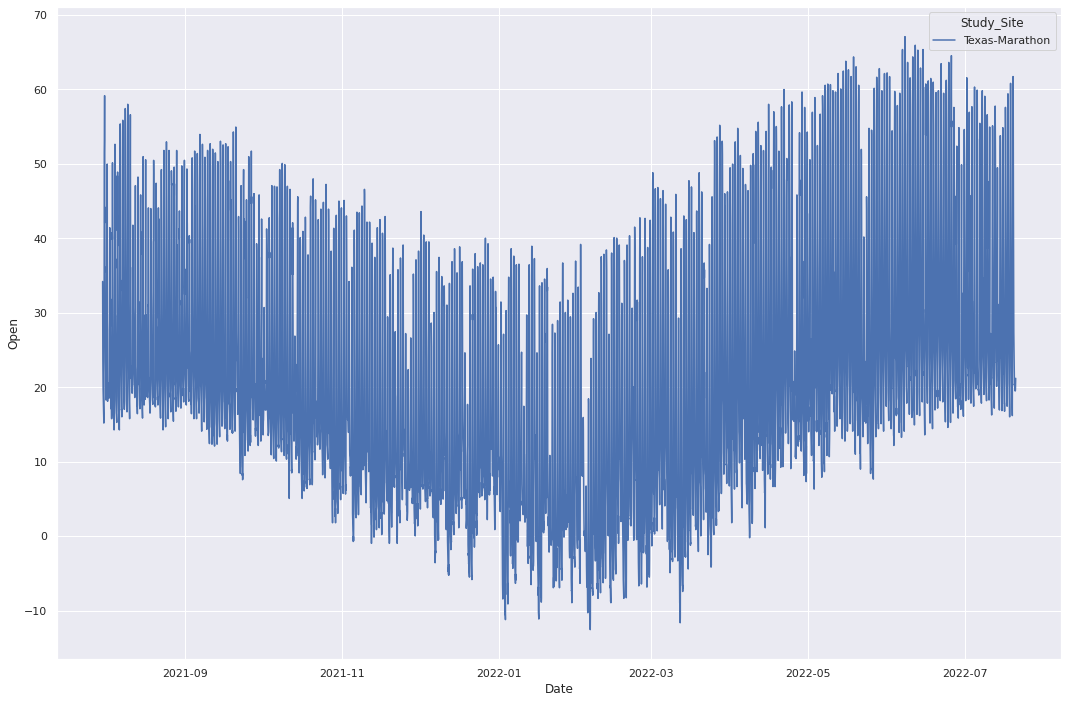

In [11]:
#sns.lineplot(data=otm_data[otm_data['Microhabitat'] == 'Air_Temperature'], x = "Date",y = "Temperature", label='Air')
plt.figure(figsize=(18, 12))
sns.lineplot(data=otm_data[otm_data['Study_Site']=='Texas-Marathon'], x = "Date",y = "Open", hue = 'Study_Site')


In [30]:
date = '2021-09-01'

# Make sure to use parentheses for each condition and correct the DataFrame column names
filtered_data = otm_data[(otm_data['Study_Site'] == 'Texas-Marathon') & (otm_data['Date'] == date)]

filtered_data.head()

,index,Date,year,month,day,hour,minute,season,Study_Site,Air_Temperature,Burrow,NaN,Open,Shrub


In [48]:
otm_data.head(30000)

,index,Date,year,month,day,hour,minute,season,Study_Site,Air_Temperature,Burrow,NaN,Open,Shrub
0,3321,2021-06-14 18:30:01,2021,6,14,18,30,Spring,Texas-Marathon,NaN,NaN,19.554,NaN,NaN
1,4479,2021-06-14 18:35:01,2021,6,14,18,35,Spring,Texas-Marathon,NaN,NaN,20.054,NaN,NaN
2,14882,2021-06-14 18:40:01,2021,6,14,18,40,Spring,Texas-Marathon,NaN,NaN,20.555,NaN,NaN
3,43210,2021-06-14 18:45:01,2021,6,14,18,45,Spring,Texas-Marathon,NaN,NaN,21.555,NaN,NaN
4,6864,2021-06-14 18:50:01,2021,6,14,18,50,Spring,Texas-Marathon,NaN,NaN,21.555,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,20553,2022-11-21 22:10:01,2022,11,21,22,10,Autumn,Texas-Monohans,4.515,12.604857,14.137,3.306000,5.214250
29996,21749,2022-11-21 22:20:01,2022,11,21,22,20,Autumn,Canada,-6.990,0.054000,-1.470,-2.200500,-3.465333
29997,22923,2022-11-21 23:20:01,2022,11,21,23,20,Autumn,Nebraska,-5.517,-0.488000,NaN,-10.357333,-9.340000
29998,5920,2022-11-21 23:20:01,2022,11,21,23,20,Autumn,Texas-Monohans,3.011,12.461714,14.137,2.299500,3.957750


## Merge Data Set

In [13]:
therma_df = pd.merge_asof(snake_data, otm_data, on='Date', by='Study_Site',direction='forward').reset_index(drop=True)
# columns_to_mean = ['Date', 'Study_Site','Snake_Name', 'Temperature', 'Air_Temperature', 'Open', 'Burrow', 'Shrub']
# therma_df = therma_df[columns_to_mean]
therma_df = therma_df.rename(columns={'Temperature': 'Body',
                                     'Air_Temperature': 'Air'})
#therma_df.drop('Shrub', axis=1, inplace=True)
columns_to_drop = ['season','Unit', 'file_name', 'index_x','year_x', 'month_x', 'day_x', 'hour_x', 'minute_x','index_y','year_y', 'month_y','day_y','hour_y','minute_y']
columns_to_drop.extend([col for col in therma_df.columns if 'NaN' in col])

therma_df = therma_df.drop(columns=columns_to_drop)
columns_to_check = ['Body', 'Air', 'Open', 'Burrow']
therma_df = therma_df.dropna(subset=columns_to_check).sort_values(by=['Snake_Name','Date'], ascending=True).reset_index(drop=True)
therma_df.head()

,Date,Body,Study_Site,Snake_Name,Air,Burrow,Open,Shrub
0,2022-07-07 23:00:01,25.053,Canada,Albert,19.077,18.73725,17.368,17.961667
1,2022-07-08 00:10:01,25.053,Canada,Albert,19.077,18.73725,18.119,18.462333
2,2022-07-08 01:20:01,25.053,Canada,Albert,18.077,18.61225,17.368,17.794667
3,2022-07-08 02:30:01,24.553,Canada,Albert,16.575,17.86150,15.865,16.458667
4,2022-07-08 03:40:01,24.553,Canada,Albert,15.574,16.98475,14.863,15.122333


## Save Data

In [15]:
date = dt.today().strftime('%Y_%m_%d')
therma_df.to_csv(f'raw_therma_data_{date}.csv', index=False)

## NA Analysis

In [40]:
rows_with_missing_data = therma_df[therma_df.isnull().any(axis=1)]

In [41]:
rows_with_missing_data.groupby('Study_Site').size()

Study_Site
Canada             3048
Nebraska          14306
Texas-Marathon    72937
dtype: int64

In [118]:
rows_with_missing_data.groupby(['Study_Site','Snake_Name', 'month_x']).size()

Study_Site      Snake_Name  month_x
Canada          Albert      5            9
                            6          447
                Cooper      5            8
                            6          448
                Eddie       5            9
                                      ... 
Texas-Marathon  Tornado     8          638
                            9          617
                            10         637
                            11         618
                            12         638
Length: 131, dtype: int64

In [44]:
therma_df.groupby('Study_Site').size()

Study_Site
Canada            88595
Nebraska           1444
Texas-Marathon    72937
dtype: int64

## Check If it worked

In [57]:
rows_with_missing_data = therma_df[therma_df.isnull().any(axis=1)]
rows_with_missing_data.groupby('Study_Site').size()

Series([], dtype: int64)

In [43]:
therma_df[therma_df['Snake_Name']=='Horace'].head()

,index_x,Date,Unit,Body,year_x,month_x,day_x,hour_x,minute_x,Study_Site,...,month_y,day_y,hour_y,minute_y,season,Air,Burrow,NaN,Open,Shrub
70833,1039,2022-07-01 00:40:01,C,26.125,2022,7,1,0,40,Nebraska,...,7.0,1.0,0.0,40.0,Summer,20.553,26.461,NaN,19.1345,20.6155
70851,1040,2022-07-01 01:50:01,C,26.125,2022,7,1,1,50,Nebraska,...,7.0,1.0,1.0,50.0,Summer,19.552,25.461,NaN,18.3835,19.6145
70869,1041,2022-07-01 03:00:01,C,26.125,2022,7,1,3,0,Nebraska,...,7.0,1.0,3.0,0.0,Summer,18.551,24.961,NaN,18.1335,19.3640
70887,1042,2022-07-01 04:10:01,C,26.125,2022,7,1,4,10,Nebraska,...,7.0,1.0,4.0,10.0,Summer,19.052,24.461,NaN,18.1335,19.1135
70905,1043,2022-07-01 05:20:01,C,26.125,2022,7,1,5,20,Nebraska,...,7.0,1.0,5.0,20.0,Summer,18.551,23.961,NaN,18.1335,19.1135


In [13]:
therma_df['Snake_Name'].unique()

array(['Ringo', 'Tornado', 'Cher', 'Nando', 'Cladwell', 'Janis',
       'Cecilia', 'Caezar', 'Hector', 'Bonnie', 'Manitoba', 'Horace',
       'Ragnar', 'Cooper', 'Moose', 'Victor', 'Kokanee', 'Eddie',
       'Hunter', 'Paloma', 'Albert'], dtype=object)

<Axes: xlabel='Date', ylabel='Open'>

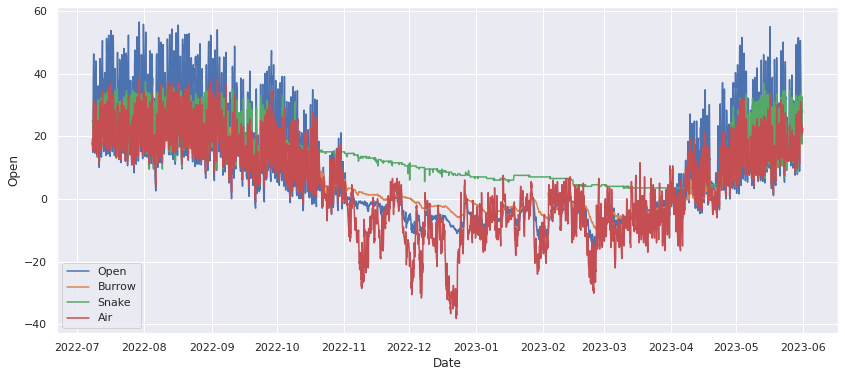

In [14]:
sns.set(style="darkgrid")
plt.figure(figsize=(14, 6))
snake_name = 'Albert'

sns.lineplot(x='Date', y='Open', data=therma_df[therma_df['Snake_Name']==snake_name], label='Open')

sns.lineplot(x='Date', y='Burrow', data=therma_df[therma_df['Snake_Name']==snake_name], label='Burrow')

sns.lineplot(x='Date', y='Body', data=therma_df[therma_df['Snake_Name']==snake_name], label='Snake')

sns.lineplot(x='Date', y='Air', data=therma_df[therma_df['Snake_Name']==snake_name], label='Air')

In [109]:
therma_df.groupby('Study_Site')['Snake_Name'].unique()

Study_Site
Canada            [Hector, Eddie, Manitoba, Cooper, Moose, Victo...
Nebraska                                                    [Bjorn]
Texas-Marathon    [Ringo, Tornado, Cher, Nando, Cladwell, Janis,...
Name: Snake_Name, dtype: object

In [110]:
snake_data.groupby('Study_Site')['Snake_Name'].unique()

Study_Site
Canada            [Hector, Eddie, Manitoba, Cooper, Moose, Victo...
Nebraska                                                    [Bjorn]
Texas-Marathon    [Ringo, Tornado, Cher, Nando, Cladwell, Janis,...
Name: Snake_Name, dtype: object

## Current Sampling Frequency

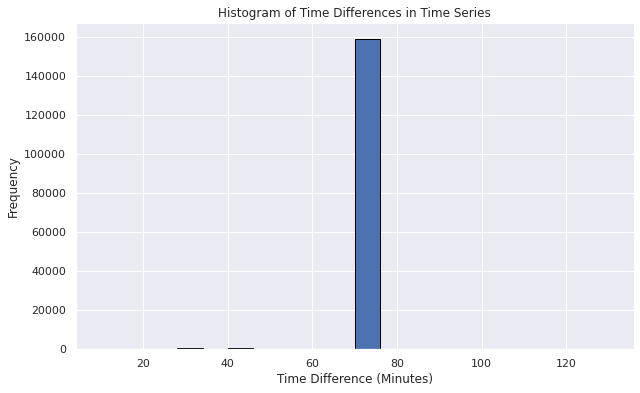

In [44]:
time_diff = therma_df.groupby('Snake_Name')['Date'].diff().dt.total_seconds()/60
 
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(time_diff, bins=20, edgecolor='black')
plt.title('Histogram of Time Differences in Time Series')
plt.xlabel('Time Difference (Minutes)')
plt.ylabel('Frequency')
plt.show()

## Interpolate Data

In [63]:
## Up sample
resampled_therma_df = therma_df.dropna().set_index('Date')
resampled_therma_df = resampled_therma_df.groupby(['Study_Site', 'Snake_Name']).resample('15T').mean()
resampled_therma_df = resampled_therma_df.reset_index()

In [64]:
resampled_therma_df.head()

,Study_Site,Snake_Name,Date,Body,Air,Burrow,Open,Shrub
0,Canada,Albert,2022-07-07 23:00:00,25.053,19.077,18.73725,17.368,17.961667
1,Canada,Albert,2022-07-07 23:15:00,NaN,NaN,NaN,NaN,NaN
2,Canada,Albert,2022-07-07 23:30:00,NaN,NaN,NaN,NaN,NaN
3,Canada,Albert,2022-07-07 23:45:00,NaN,NaN,NaN,NaN,NaN
4,Canada,Albert,2022-07-08 00:00:00,25.053,19.077,18.73725,18.119,18.462333


In [65]:
## Interpolation functions
#https://docs.scipy.org/doc/scipy/tutorial/interpolate.html

def group_rolling_mean_imputation(group_df, column_name, rolling_mean_window):
    imputed_data = list(group_df[columns_to_impute].rolling(window=rolling_mean_window, min_periods=1).mean())
    return group_df

def group_knn_imputation(group_df, column_name, n_neighbors=3):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = list(imputer.fit_transform(group_df[column_name]))
    return imputed_data

def linear_group_interpolate(group_df, column_name):
    imputed_data = list(group_df[column_name].interpolate(method='linear'))
    return imputed_data

def cspline_impute_group(group, order=3):
    group_imputed = group.interpolate(method='spline', order=order)
    return group_imputed

def interpolate_by_snake_cspline( df, column_name, order=3):
    grouped_df = df.groupby('Snake_Name')
    # Apply the imputation function to each group
    imputed_df = grouped_df.apply(lambda x: cspline_impute_group(x[column_name]))
    return imputed_df

def akima_impute_group(group, column_name):
    # Separate NaN and non-NaN values
    non_nan_values = group.dropna(subset=[column_name])
    nan_values = group[group[column_name].isna()]

    if len(non_nan_values) > 1:
        # Use Akima1DInterpolator for imputation within each group
        interpolator = Akima1DInterpolator(non_nan_values.index, non_nan_values[column_name])
        group_imputed_values = interpolator(nan_values.index)
        group_imputed = pd.Series(group_imputed_values, index=nan_values.index)
        return group_imputed.reindex(group.index).fillna(group[column_name])
    else:
        # If there are not enough points for interpolation, return the original group
        return group[column_name]

def interpolate_by_snake_akima(df, column_name):
    snakes = df['Snake_Name'].unique()
    total_data = []
    for snake in snakes:
        condition1 = df['Snake_Name']==snake
        temp_df = df.loc[condition1][['Date',column_name]]
        temp_df_naomit = temp_df.dropna()
        x = temp_df_naomit.index
        y = temp_df_naomit[column_name]
        interpolator = Akima1DInterpolator(x, y)
        for index, row in temp_df.iterrows():
            if len(temp_df_naomit) >= 2:
                val = float(interpolator(index))
                total_data.append(val)
            else:
                total_data.append(np.NaN)
    return total_data


In [66]:
# CS Interpolator
body_cs = interpolate_by_snake_cspline(df=resampled_therma_df, column_name='Body')
resampled_therma_df['Body_CS'] = list(body_cs)

In [67]:
# Akima Interpolator
body_akima = interpolate_by_snake_akima(df=resampled_therma_df, column_name='Body')
resampled_therma_df['Body_ak'] = list(body_akima)

In [16]:
float(body_akima[0])

25.053

In [68]:
resampled_therma_df.head()

,Study_Site,Snake_Name,Date,Body,Air,Burrow,Open,Shrub,Body_CS,Body_ak
0,Canada,Albert,2022-07-07 23:00:00,25.053,19.077,18.73725,17.368,17.961667,25.053000,25.053
1,Canada,Albert,2022-07-07 23:15:00,NaN,NaN,NaN,NaN,NaN,26.689174,25.053
2,Canada,Albert,2022-07-07 23:30:00,NaN,NaN,NaN,NaN,NaN,26.276037,25.053
3,Canada,Albert,2022-07-07 23:45:00,NaN,NaN,NaN,NaN,NaN,25.885813,25.053
4,Canada,Albert,2022-07-08 00:00:00,25.053,19.077,18.73725,18.119,18.462333,25.053000,25.053


In [71]:
sns.set(style="darkgrid")
snake_name = 'Horace'
temp_snake = resampled_therma_df[resampled_therma_df['Snake_Name']==snake_name]
temp_snake = temp_snake.loc[(temp_snake['Date'] >= '2022-08-01') & (temp_snake['Date'] <= '2022-09-03')]

plt.figure(figsize=(14, 6))
#sns.lineplot(x='Date', y='Body_CS', data=temp_snake, label='cspline')
sns.lineplot(x='Date', y='Body_ak', data=temp_snake, label='AK')
sns.lineplot(x='Date', y='Body', data=temp_snake, label='Snake')

ValueError: Could not interpret value `Body_ak` for `y`. An entry with this name does not appear in `data`.

<Figure size 1008x432 with 0 Axes>

In [70]:
# Specify columns for which you want to perform imputation
columns_to_impute = ['Air', 'Burrow', 'Open', 'Body']

for column in columns_to_impute:
    # Akima Interpolator
    akima = interpolate_by_snake_akima(df=resampled_therma_df, column_name=column)
    new_name = column + '_ak'
    resampled_therma_df[new_name] = list(akima)
    resampled_therma_df[column].fillna(resampled_therma_df[new_name], inplace=True)
    resampled_therma_df.drop(new_name, axis=1, inplace=True)

<Axes: xlabel='Date', ylabel='Open'>

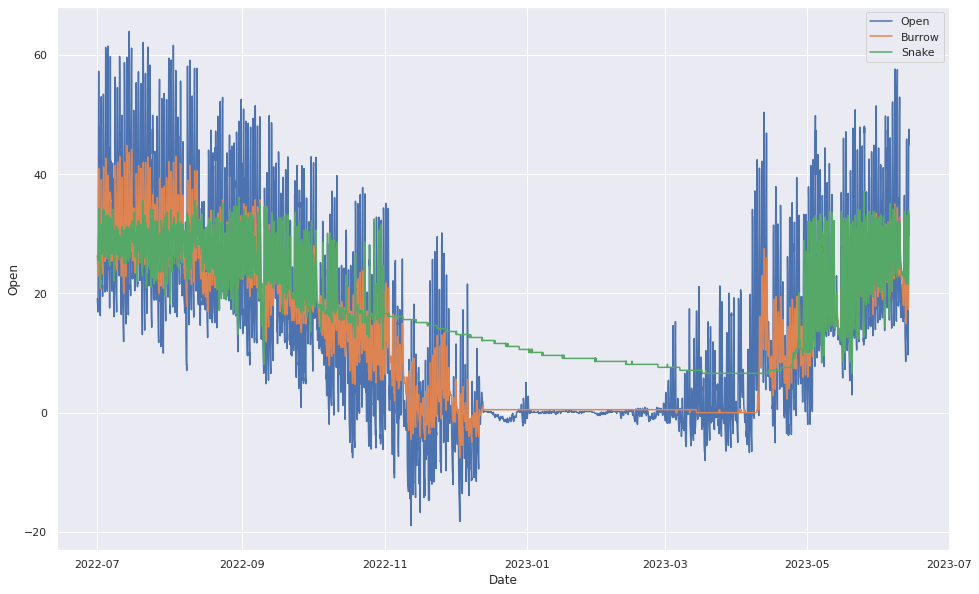

In [72]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 10))
snake_name = 'Horace'
temp_snake = resampled_therma_df[resampled_therma_df['Snake_Name']==snake_name]
#temp_snake = temp_snake.loc[(temp_snake['Date'] >= '2022-08-01') & (temp_snake['Date'] <= '2022-09-03')]

sns.lineplot(x='Date', y='Open', data=temp_snake, label='Open')
sns.lineplot(x='Date', y='Burrow', data=temp_snake, label='Burrow')
sns.lineplot(x='Date', y='Body', data=temp_snake, label='Snake')


In [75]:
#resampled_therma_df.drop('Shrub', axis=1, inplace=True)
resampled_therma_df.drop('Body_CS', axis=1, inplace=True)
resampled_therma_df.head()

,Study_Site,Snake_Name,Date,Body,Air,Burrow,Open
0,Canada,Albert,2022-07-07 23:00:00,25.053,19.077000,18.737250,17.368000
1,Canada,Albert,2022-07-07 23:15:00,25.053,19.158217,18.745062,17.694649
2,Canada,Albert,2022-07-07 23:30:00,25.053,19.193578,18.745581,17.944922
3,Canada,Albert,2022-07-07 23:45:00,25.053,19.170650,18.741935,18.094484
4,Canada,Albert,2022-07-08 00:00:00,25.053,19.077000,18.737250,18.119000


In [76]:
date = dt.today().strftime('%Y_%m_%d')
resampled_therma_df.to_csv(f'imp_therma_data_{date}.csv', index=False)

In [19]:
resampled_therma_df['Snake_Name'].unique()

array(['Albert', 'Cooper', 'Eddie', 'Hector', 'Hunter', 'Kokanee',
       'Manitoba', 'Moose', 'Paloma', 'Victor', 'Bjorn', 'Bonnie',
       'Caezar', 'Cecilia', 'Cher', 'Cladwell', 'Janis', 'Nando', 'Ringo',
       'Tornado'], dtype=object)

In [77]:
pd.__version__

'2.0.3'